Importing Modules

In [4]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

Mounting Google Drive to access Training Data

In [5]:
from google.colab import drive
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


Loading train & test data into memory

In [40]:
trainX = np.load("drive/MyDrive/Datasets/lc/v4/trainX.npy").astype(np.float32)
trainY = np.load("drive/MyDrive/Datasets/lc/v4/trainY.npy").astype(np.float32)
testX = np.load("drive/MyDrive/Datasets/lc/v4/testX.npy").astype(np.float32)
testY = np.load("drive/MyDrive/Datasets/lc/v4/testY.npy").astype(np.float32)

In [7]:
# unique, counts = np.unique(trainY, return_counts=True)
# print(unique, counts)

Normalizing values

In [41]:
trainX = (trainX-127.0)/127.0
testX = (testX-127.0)/127.0
trainY = (trainY>127).astype(np.float32)
testY = (testY>127).astype(np.float32)

In [9]:
print(trainX.dtype)
print(trainY.dtype)
print(testX.dtype)
print(testY.dtype)

float32
float32
float32
float32


Reshaping train & test data

In [42]:
trainX = np.reshape(trainX, (len(trainX), 512, 512, 1))
trainY = np.reshape(trainY, (len(trainY), 512, 512, 1))
testX = np.reshape(testX, (len(testX), 512, 512, 1))
testY = np.reshape(testY, (len(testY), 512, 512, 1))

print("trainX:",trainX.shape)
print("trainY:",trainY.shape)
print("testX:",testX.shape)
print("testY:",testY.shape)

trainX: (1349, 512, 512, 1)
trainY: (1349, 512, 512, 1)
testX: (8, 512, 512, 1)
testY: (8, 512, 512, 1)


Evaluation Metrics for U-Net model

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Defining U-Net model architecture

In [12]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    K.set_image_data_format('channels_last')

    #Encoder
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    #BottleNeck
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(conv5)

    #Decoder
    up6 = concatenate([Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), padding="same")(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(conv6)

    up7 = concatenate([Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), padding="same")(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(conv7)

    up8 = concatenate([Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), padding="same")(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(up8)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(conv8)

    up9 = concatenate([Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), padding="same")(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(up9)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(conv9)

    conv10 = Conv2D(1, (1,1), activation="sigmoid")(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Connecting to TPU cluster system for faster training

In [13]:
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)

Callback functions for U-Net model training

In [14]:
weight_path="checkpoint-{epoch:03d}-{val_dice_coef:.3f}.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                   patience=3,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=30)

CALLBACKS = [checkpoint, early, reduceLROnPlat]

Creating U-Net model

In [15]:
with strategy.scope():
  model = unet(input_size=(512,512,1))
  model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
              metrics = [dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

Train model

In [16]:
history = model.fit(x = trainX,
                    y = trainY,
                    batch_size = 32,
                    epochs = 250,
                    validation_data =(testX,testY),
                    callbacks=CALLBACKS
                  )

Epoch 1/250
43/43 [==============================] - ETA: 0s - loss: -0.0070 - dice_coef: 0.0157 - binary_accuracy: 0.9921
Epoch 1: val_loss improved from inf to -0.04312, saving model to checkpoint-001-0.064.hdf5
43/43 [==============================] - 101s 2s/step - loss: -0.0070 - dice_coef: 0.0157 - binary_accuracy: 0.9921 - val_loss: -0.0431 - val_dice_coef: 0.0644 - val_binary_accuracy: 0.9989 - lr: 2.0000e-04
Epoch 2/250
43/43 [==============================] - ETA: 0s - loss: -0.0988 - dice_coef: 0.1070 - binary_accuracy: 0.9970
Epoch 2: val_loss improved from -0.04312 to -0.17507, saving model to checkpoint-002-0.192.hdf5
43/43 [==============================] - 11s 266ms/step - loss: -0.0988 - dice_coef: 0.1070 - binary_accuracy: 0.9970 - val_loss: -0.1751 - val_dice_coef: 0.1920 - val_binary_accuracy: 0.9979 - lr: 2.0000e-04
Epoch 3/250
43/43 [==============================] - ETA: 0s - loss: -0.2435 - dice_coef: 0.2490 - binary_accuracy: 0.9985
Epoch 3: val_loss improved f

Plotting the history of training

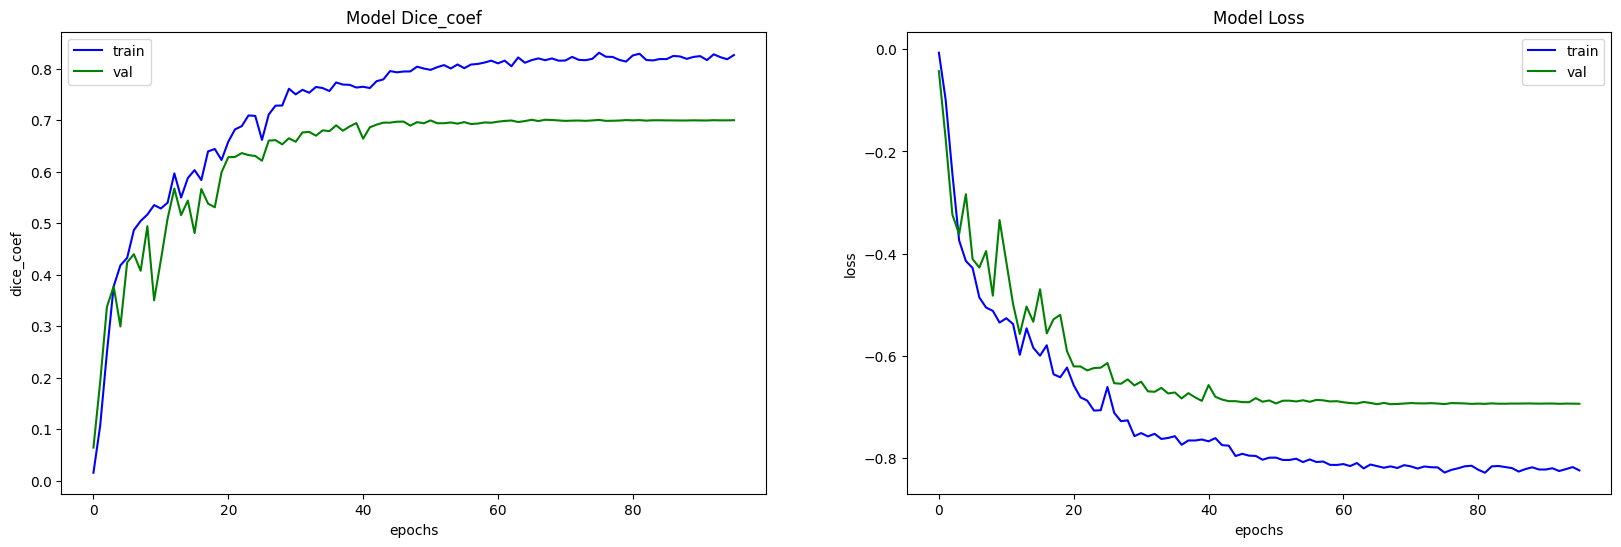

In [17]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['dice_coef', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

Saving model history for future use

In [18]:
import pickle
with open('LC_UNet_trainHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
# To load history
# history = pickle.load(open('DenseNet121trainHistory', "rb"))

Save the model

In [19]:
model.save("LC_v4_UNet_cl.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
model.evaluate(testX, testY)

11/11 [==============================] - 2s 91ms/step - loss: -0.6935 - dice_coef: 0.6998 - binary_accuracy: 0.9996


[-0.6934941411018372, 0.6997849345207214, 0.9996106624603271]

In [22]:
with strategy.scope():
  model2 = unet(input_size=(512,512,1))
  model2.load_weights("checkpoint-063-0.699.hdf5")

  model2.compile(optimizer=Adam(learning_rate=2e-4),
                loss=[dice_coef_loss],
                metrics = [dice_coef, 'binary_accuracy'])

model2.evaluate(testX, testY)

11/11 [==============================] - 29s 1s/step - loss: -0.6929 - dice_coef: 0.6992 - binary_accuracy: 0.9996


[-0.6928566098213196, 0.6991665363311768, 0.9996076226234436]

In [29]:
model2.save("LC_v4_UNet_best_Model_checkpoint_cl.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 454ms/step


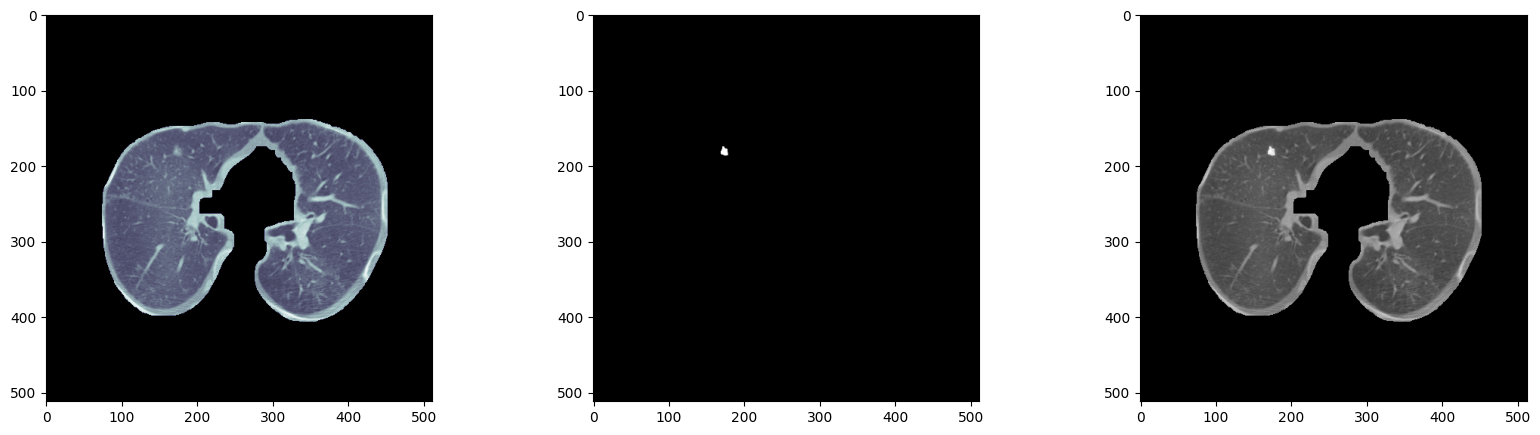

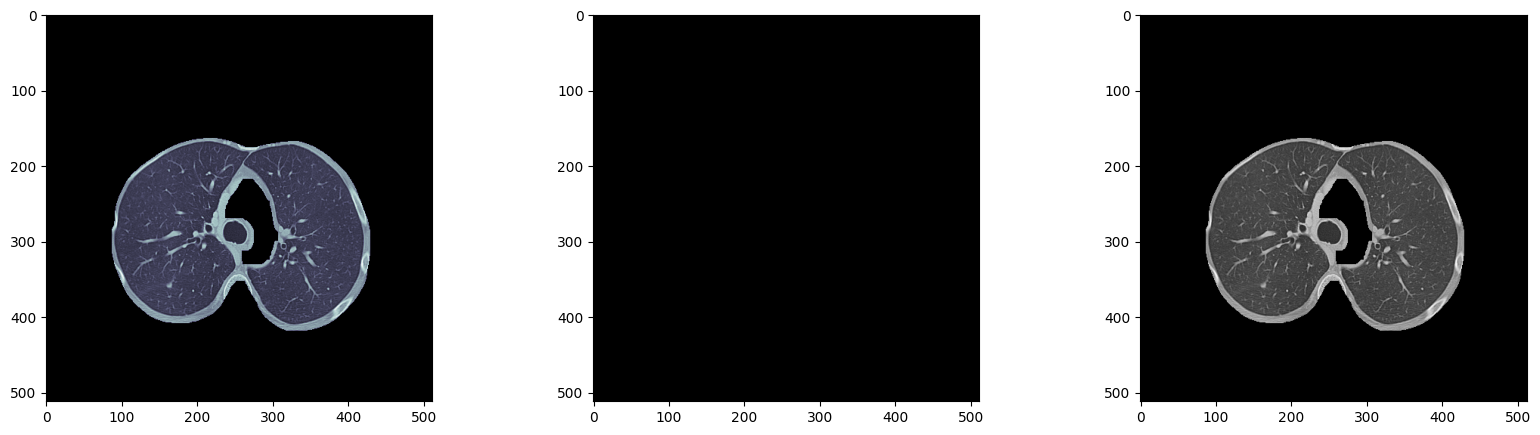

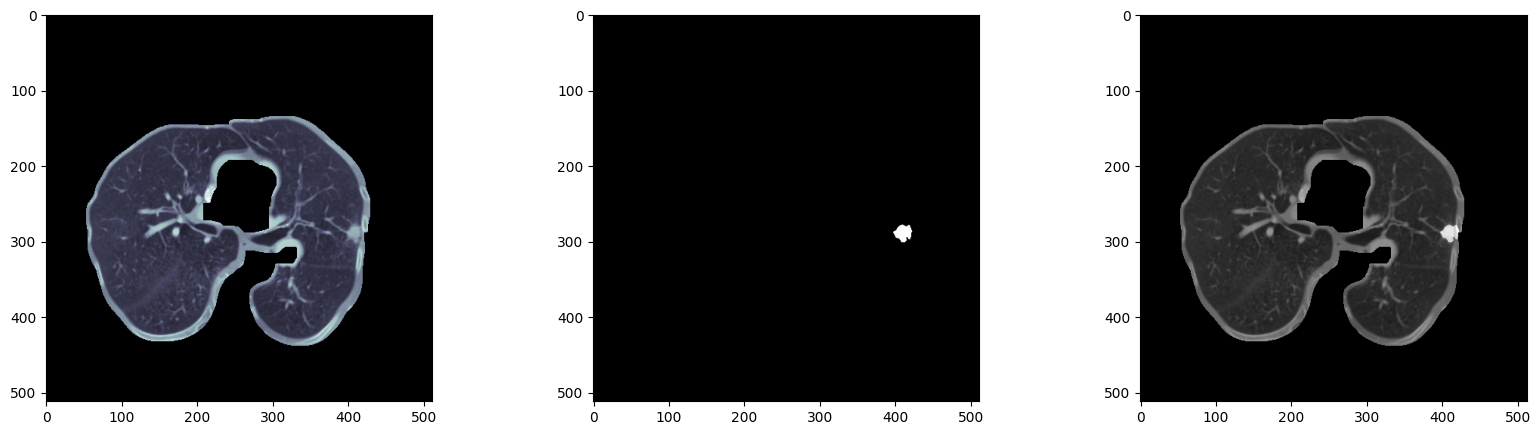

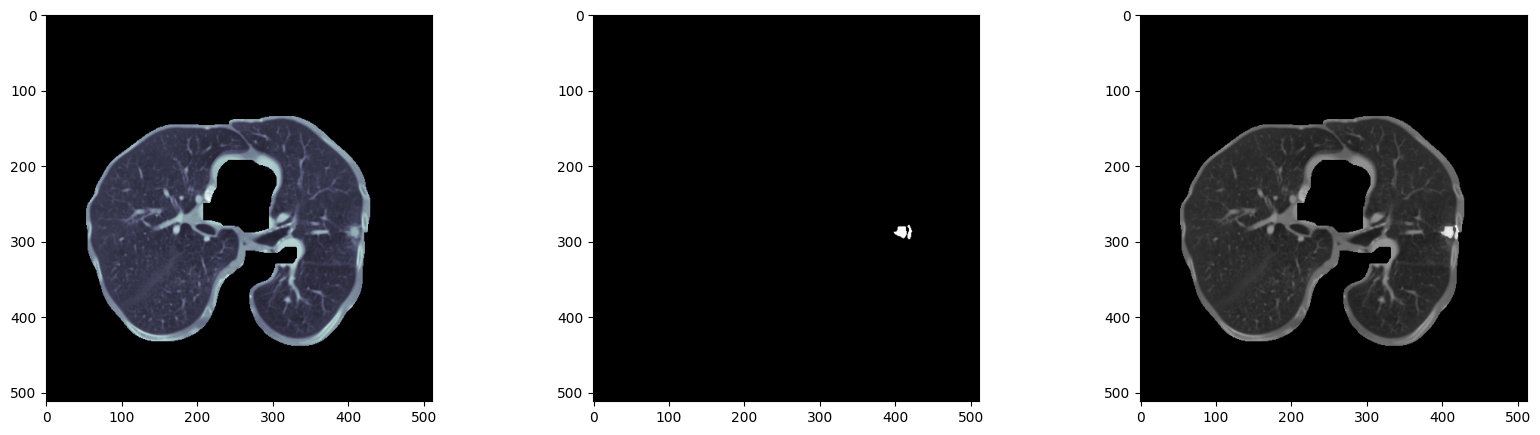

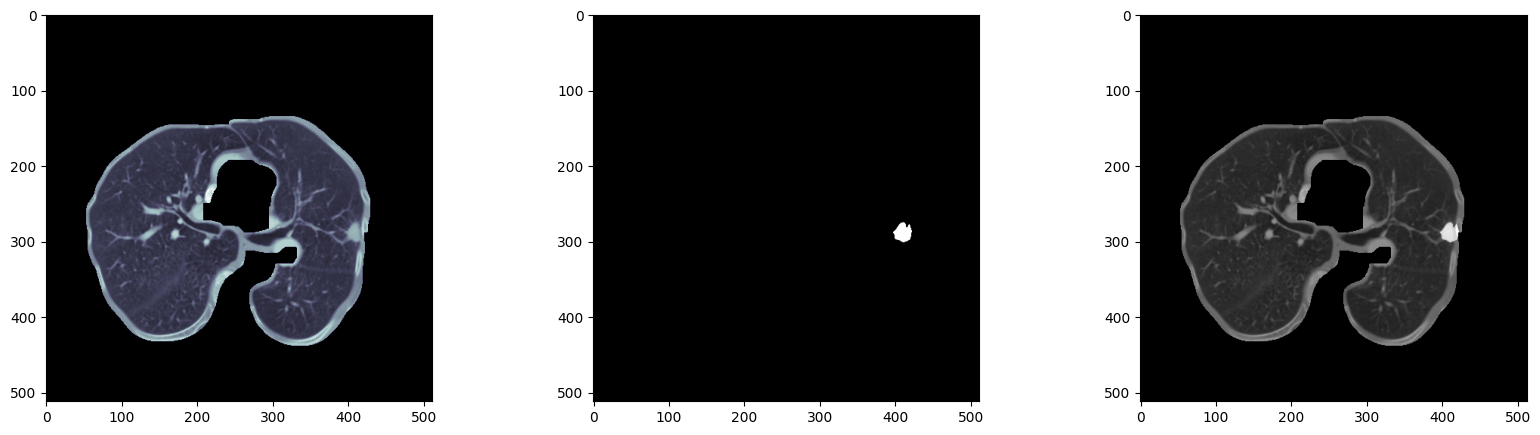

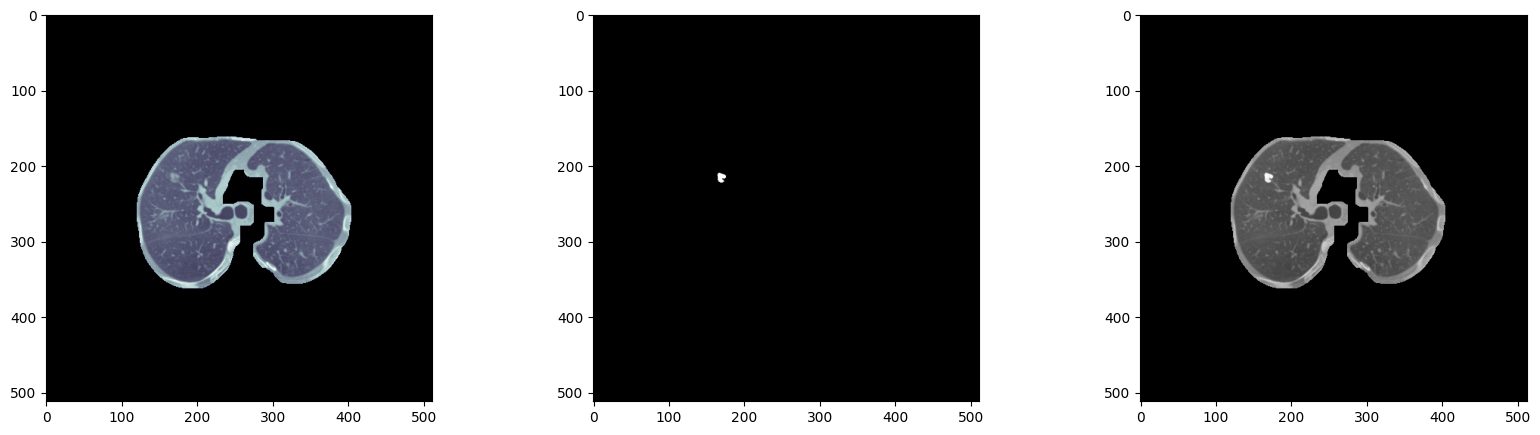

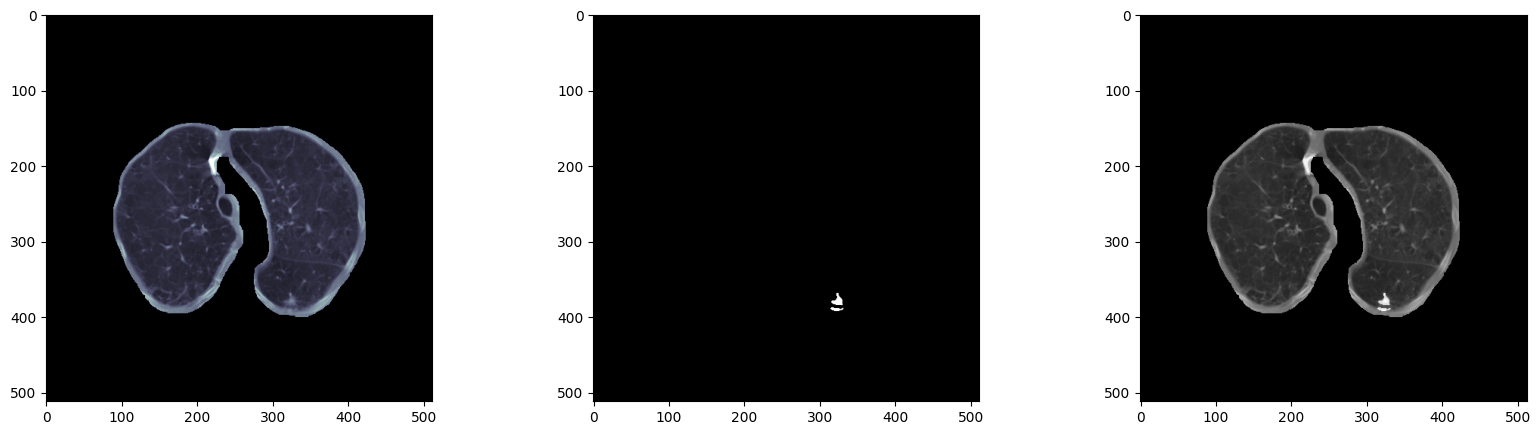

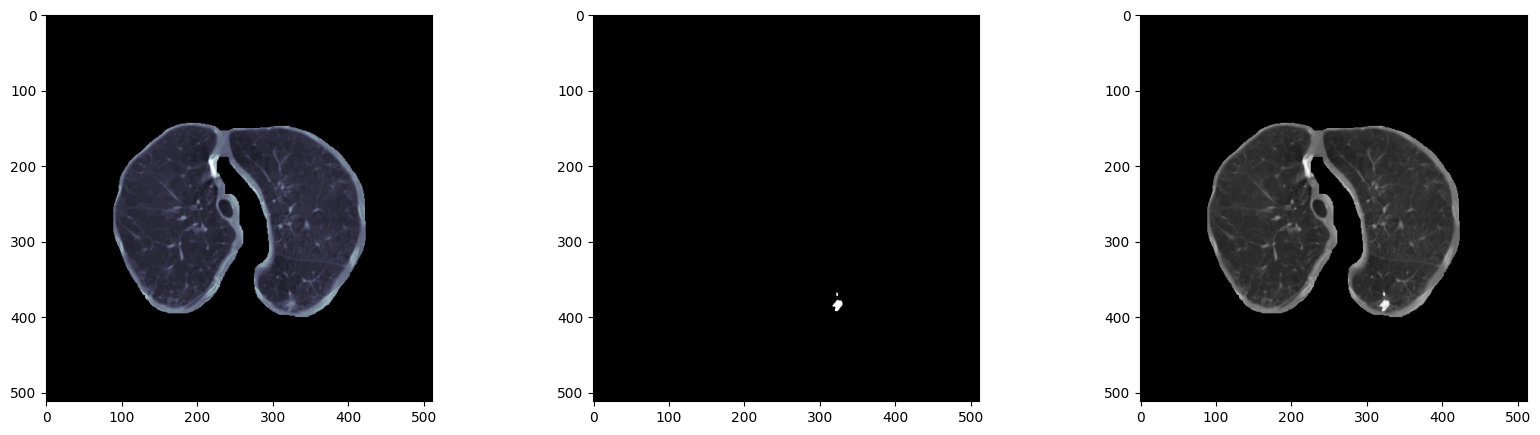

In [43]:
j = 1
for i in range(0,8):
  test = np.squeeze(testX)[i]
  t_p = model.predict(np.reshape(test, (1,512,512,1)))

  plt.figure(figsize=(20,300))
  plt.subplot(50,3,j)
  plt.imshow(np.squeeze(test), cmap="bone")
  plt.subplot(50,3,j+1)
  plt.imshow(np.squeeze(t_p), cmap="gray")
  plt.subplot(50,3,j+2)
  plt.imshow(cv2.addWeighted(np.squeeze(test), .5, np.squeeze(t_p), .5, 0), cmap="gray")
  j += 3

In [ ]:
!cp LC_v4_UNet_cl.h5 drive/MyDrive/Datasets/lc/v4/Training_Logs/1st_Trial/LC_v4_UNet.h5
!cp LC_UNet_trainHistory drive/MyDrive/Datasets/lc/v4/Training_Logs/1st_Trial/LC_UNet_trainHistory

In [ ]:
!cp LC_v4_UNet_best_Model_checkpoint_cl.h5 drive/MyDrive/Datasets/lc/v4/Training_Logs/1st_Trial/LC_UNet_best_Model_checkpoint.h5

Loading the checkpoint model

Save the checkpoint model